In [1]:
import pickle

import numpy as np
import torch
import os
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
os.chdir('/Users/gouse/PycharmProjects/AR-Imperial-Thesis')
os.getcwd()

'/Users/gouse/PycharmProjects/AR-Imperial-Thesis'

In [3]:
feature_names_with_bins = ["thickness_small", "thickness_medium", "thickness_large", "thickness_xlarge",
                 "width_small", "width_medium", "width_large", "width_xlarge",
                 "length_small", "length_medium", "length_large", "length_xlarge"]
feature_names_with_new_bins = ["thickness_small", "thickness_medium", "thickness_large",
                 "width_small", "width_medium", "width_large",
                 "length_small", "length_medium", "length_large"]
feature_names = ["thickness", "width", "length"]

class_names = ["7", "8", "9"]

# mapping from feature index to feature name
feature_index_to_name = {i: feature_name for i, feature_name in enumerate(feature_names)}
feature_index_to_name_new_bins = {i: feature_name for i, feature_name in enumerate(feature_names_with_new_bins)}
# mapping from feature name to feature index
feature_name_to_index = {feature_name: i for i, feature_name in enumerate(feature_names)}
# mapping from class index to class name
class_index_to_name = {i: class_name for i, class_name in enumerate(class_names)}
# mapping from class name to class index
class_name_to_index = {class_name: i for i, class_name in enumerate(class_names)}

In [4]:
# Download training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

train_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=False,
                              download=True,
                              transform=transform)

dict_of_lists = {7: [], 8: [], 9: []}
for i, (_, label) in enumerate(train_dataset):
    if label in dict_of_lists.keys():
        dict_of_lists[label].append(
            train_dataset.data[i].reshape(1, 28, 28))

for key in dict_of_lists.keys():
    dict_of_lists[key] = np.vstack(dict_of_lists[key]).reshape(-1, 1,
                                                               28, 28)
    if key == 8:
        X = torch.cat((torch.tensor(dict_of_lists[7]),
                       torch.tensor(dict_of_lists[8])))
    elif key > 8:
        X = torch.cat((X, torch.tensor(dict_of_lists[key])))

# import pickle files
with open('./datasets/MNIST/mine_preprocessed/area_dict.pkl', 'rb') as f:
    area = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict.pkl', 'rb') as f:
    length = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict.pkl', 'rb') as f:
    thickness = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict.pkl', 'rb') as f:
    slant = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict.pkl', 'rb') as f:
    width = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict.pkl', 'rb') as f:
    height = pickle.load(f)

# load the targets test
with open('./datasets/MNIST/mine_preprocessed/area_dict_test.pkl', 'rb') as f:
    area_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict_test.pkl', 'rb') as f:
    length_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict_test.pkl', 'rb') as f:
    thickness_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict_test.pkl', 'rb') as f:
    slant_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict_test.pkl', 'rb') as f:
    width_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict_test.pkl', 'rb') as f:
    height_test = pickle.load(f)

#### Return the minimum and the maximum value per bin, and select the 5 images which have a value closer to the minimum and 5 closer to the maximum per bin

In [5]:
targets = []
digits_size = 0
labels = []
# for i in range(4,10):
for i in [7, 8, 9]:
    # targets += list(
    #     zip(thickness[i], width[i], slant[i], height[i]))
    targets += list(
        zip(thickness[i], width[i], length[i]))
    # targets += list(
    # zip(thickness[i], area[i], length[i],
    #                     width[i], height[i], slant[i]))
    if i == 7:
        k = 0
    elif i == 8:
        k = 1
    else:
        k = 2
    # labels.append([(i-4) for j in range(len(targets) - digits_size)])
    labels.append([k for j in range(len(targets) - digits_size)])
    digits_size += len(width[i])

targets = np.array(targets)

def assign_bins(data, bin_edges):
    return np.digitize(data, bins=bin_edges, right=True)

# Convert bin numbers to one-hot encoded values
def one_hot_encode(bin_numbers, num_bins):
    return np.eye(num_bins)[bin_numbers - 1]

def process_data(targets, num_bins=4):
    bins_data_all = []
    min_max_values_all = []
    closest_images_all = []
    bin_counts = []

    for i in range(targets.shape[1]):
        # Combine the data
        combined_data = list(targets[:, i])

        # Sort the combined data
        combined_sorted = np.sort(combined_data)

        # Determine the number of data points per bin
        bin_size = len(combined_sorted) // num_bins

        # Calculate bin edges
        bin_edges = [combined_sorted[i * bin_size] for i in range(1, num_bins)] + [combined_sorted[-1]]
        bin_edges = [-np.inf] + bin_edges

        # Assign bins to the original data lists
        bins_data = assign_bins(targets[:, i], bin_edges)

        # Do one-hot encoding in the bins
        bins_data_encoded = one_hot_encode(bins_data, num_bins)

        # Get min and max values per bin
        min_max_values = []
        closest_images = []
        counts = []

        for bin_num in range(1, num_bins + 1):
            bin_indices = np.where(bins_data == bin_num)[0]
            bin_values = targets[bin_indices, i]
            counts.append(len(bin_indices))

            if len(bin_values) > 0:
                min_val = np.min(bin_values)
                max_val = np.max(bin_values)
                min_max_values.append((min_val, max_val))

                # Select 5 images closest to the minimum and 5 closest to the maximum
                closest_min_indices = bin_indices[np.argsort(np.abs(bin_values - min_val))[:5]]
                closest_max_indices = bin_indices[np.argsort(np.abs(bin_values - max_val))[:5]]
                closest_images.append((closest_min_indices, closest_max_indices))
            else:
                min_max_values.append((None, None))
                closest_images.append(([], []))

        bins_data_all.append(bins_data_encoded)
        min_max_values_all.append(min_max_values)
        closest_images_all.append(closest_images)
        bin_counts.append(counts)

    return bins_data_all, min_max_values_all, closest_images_all, bin_counts

# Example usage:
#targets = np.random.randn(100, 2)  # Example targets with 2 features and 100 samples
num_bins = 3
bins_data_all, min_max_values_all, closest_images_all, bin_counts = process_data(targets, num_bins=num_bins)

# Output the results
for feature_idx in range(targets.shape[1]):
    print(f"Feature {feature_idx}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        print(f"    Closest to Min: {closest_images_all[feature_idx][bin_idx][0]}")
        print(f"    Closest to Max: {closest_images_all[feature_idx][bin_idx][1]}")


Feature 0
  Bin 1: Min = 1.0608199852609512, Max = 2.2265326234790654
    Closest to Min: [ 6297  6860 16514  1719  8968]
    Closest to Max: [ 6348 17268  2257 16796  8644]
  Bin 2: Min = 2.22660668639398, Max = 2.732116302093417
    Closest to Min: [ 7956  7056 17921  6735 17547]
    Closest to Max: [4840 6442 5356 6446  281]
  Bin 3: Min = 2.7321296898495326, Max = 9.53389237525011
    Closest to Min: [17702   711  8278  4193 10938]
    Closest to Max: [ 7227 11416  6813  8657 10884]
Feature 1
  Bin 1: Min = 5.381124287425585, Max = 11.71095269855491
    Closest to Min: [12476 10416 15361  3902 13692]
    Closest to Max: [11192   635  5700 16159 15066]
  Bin 2: Min = 11.711000597013602, Max = 14.064992052886485
    Closest to Min: [16021  1744  8004    14  9280]
    Closest to Max: [ 3922 17828  2587 10070  2344]
  Bin 3: Min = 14.06584903556787, Max = 21.544126377921508
    Closest to Min: [11491 12393  6790  6255  1840]
    Closest to Max: [ 253 3173  912  818 3170]
Feature 2
  Bi

Feature 1, Bin 1: Min = 1.0608199852609512, Max = 2.2265326234790654


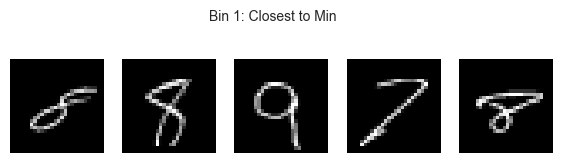

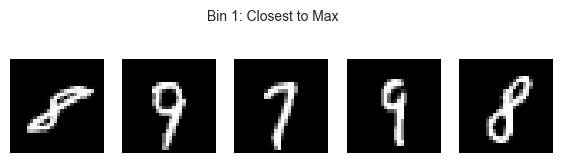

Feature 1, Bin 2: Min = 2.22660668639398, Max = 2.732116302093417


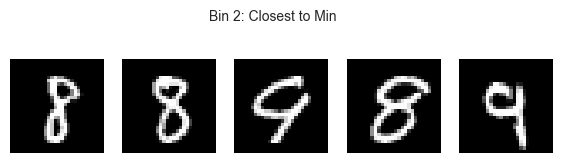

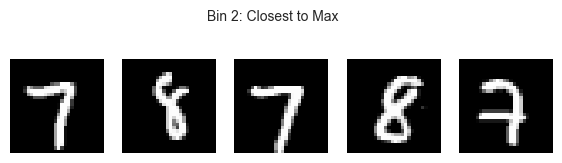

Feature 1, Bin 3: Min = 2.7321296898495326, Max = 9.53389237525011


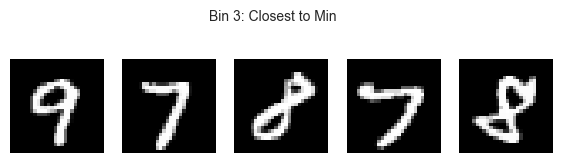

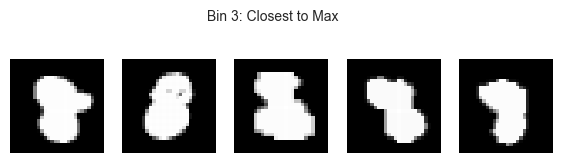

Feature 2, Bin 1: Min = 5.381124287425585, Max = 11.71095269855491


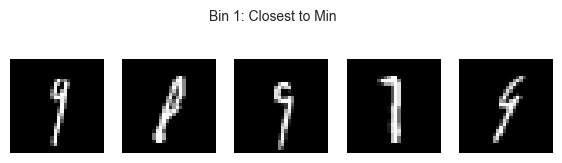

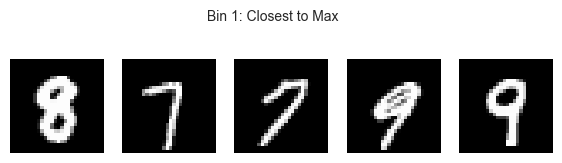

Feature 2, Bin 2: Min = 11.711000597013602, Max = 14.064992052886485


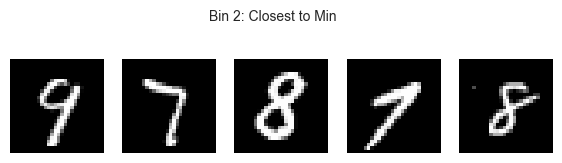

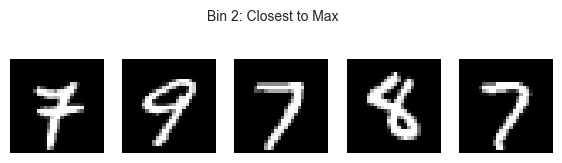

Feature 2, Bin 3: Min = 14.06584903556787, Max = 21.544126377921508


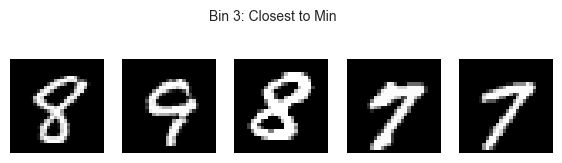

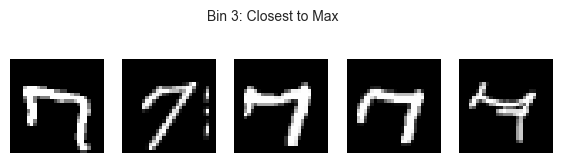

Feature 3, Bin 1: Min = 15.010407640085656, Max = 39.24873734152915


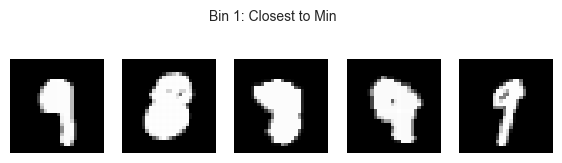

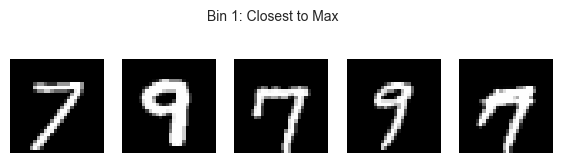

Feature 3, Bin 2: Min = 39.24873734152916, Max = 49.03427124746189


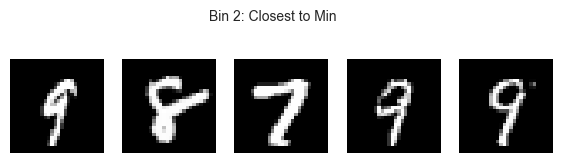

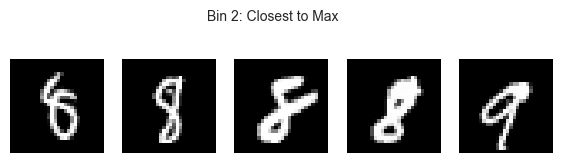

Feature 3, Bin 3: Min = 49.0416305603426, Max = 85.62615433949864


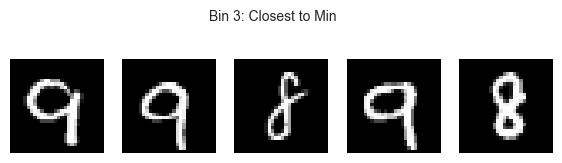

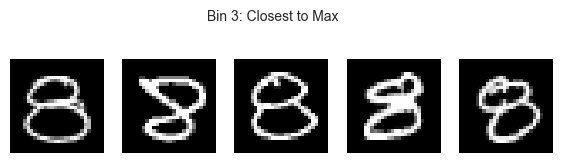

In [6]:
# Plotting the images
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(7, 2))
    fig.suptitle(title, fontsize=10)
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot closest images
for feature_idx in range(targets.shape[1]):
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"Feature {feature_idx + 1}, Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        
        closest_min_indices = closest_images_all[feature_idx][bin_idx][0]
        closest_max_indices = closest_images_all[feature_idx][bin_idx][1]
        
        if closest_min_indices.size > 0:
            plot_images(X[closest_min_indices], f"Bin {bin_idx + 1}: Closest to Min")
        if closest_max_indices.size > 0:
            plot_images(X[closest_max_indices], f"Bin {bin_idx + 1}: Closest to Max")

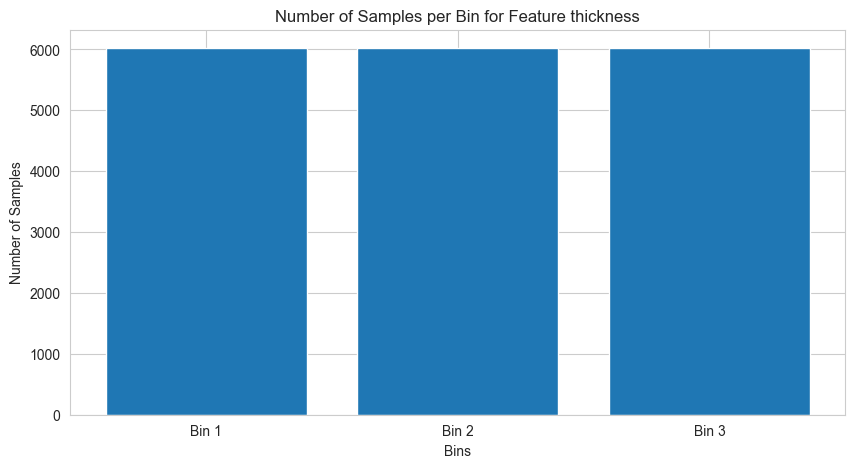

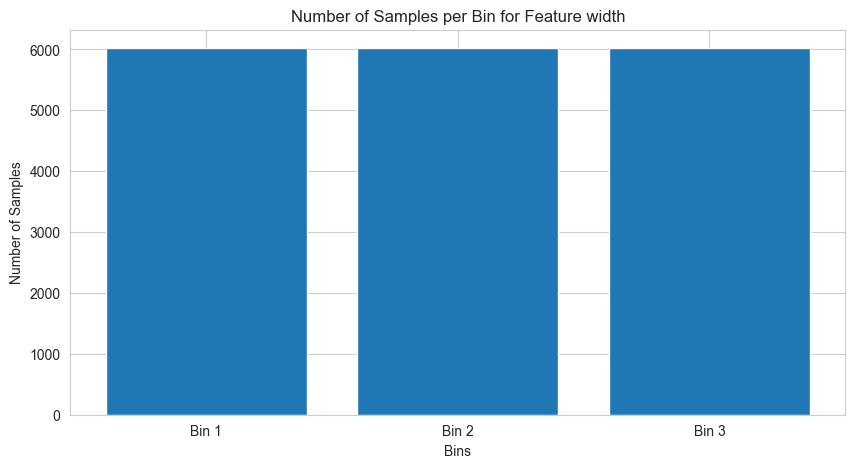

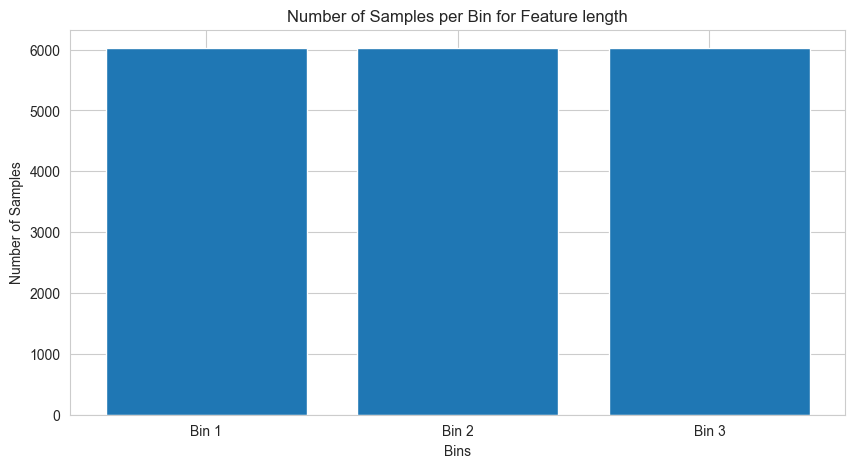

In [7]:
# Plotting the number of samples per bin per feature
for feature_idx in range(targets.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, num_bins + 1), bin_counts[feature_idx], tick_label=[f'Bin {i}' for i in range(1, num_bins + 1)])
    plt.xlabel('Bins')
    plt.ylabel('Number of Samples')
    plt.title(f'Number of Samples per Bin for Feature {feature_index_to_name[feature_idx]}')
    plt.show()

#### Change the process_data not to return bins of equal sizes but bins of equally distant features

In [8]:
def assign_bins(data, bin_edges):
    return np.digitize(data, bins=bin_edges, right=True)

# Convert bin numbers to one-hot encoded values
def one_hot_encode(bin_numbers, num_bins):
    return np.eye(num_bins)[bin_numbers - 1]

def process_data_not_equal_bins(targets, num_bins=4):
    bins_data_all_indices = {}
    bins_data_all = []
    min_max_values_all = []
    closest_images_all = []
    bin_counts = []

    for i in range(targets.shape[1]):
        # Calculate bin edges for equally distant features
        min_val, max_val = np.min(targets[:, i]), np.max(targets[:, i])
        bin_edges = np.linspace(min_val, max_val, num_bins + 1)

        # Assign bins to the original data lists
        bins_data = assign_bins(targets[:, i], bin_edges)

        # Do one-hot encoding in the bins
        bins_data_encoded = one_hot_encode(bins_data, num_bins)

        # Get min and max values per bin
        min_max_values = []
        closest_images = []
        counts = []

        feature_bins_data = {}

        for bin_num in range(1, num_bins + 1):
            bin_indices = np.where(bins_data == bin_num)[0]
            bin_values = targets[bin_indices, i]
            counts.append(len(bin_indices))

            if len(bin_values) > 0:
                min_val = np.min(bin_values)
                max_val = np.max(bin_values)
                min_max_values.append((min_val, max_val))

                # Select 5 images closest to the minimum and 5 closest to the maximum
                closest_min_indices = bin_indices[np.argsort(np.abs(bin_values - min_val))[:5]]
                closest_max_indices = bin_indices[np.argsort(np.abs(bin_values - max_val))[:5]]
                closest_images.append((closest_min_indices, closest_max_indices))
            else:
                min_max_values.append((None, None))
                closest_images.append(([], []))

            feature_bins_data[bin_num] = list(bin_indices)

        bins_data_all.append(bins_data_encoded)
        bins_data_all_indices[i] = feature_bins_data
        min_max_values_all.append(min_max_values)
        closest_images_all.append(closest_images)
        bin_counts.append(counts)

    return bins_data_all, bins_data_all_indices, min_max_values_all, closest_images_all, bin_counts

In [9]:
num_bins = 3
bins_data_all, bins_data_all_indices, min_max_values_all, closest_images_all, bin_counts = process_data_not_equal_bins(targets, num_bins=num_bins)

# Output the results
for feature_idx in range(targets.shape[1]):
    print(f"Feature {feature_idx}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        print(f"    Closest to Min: {closest_images_all[feature_idx][bin_idx][0]}")
        print(f"    Closest to Max: {closest_images_all[feature_idx][bin_idx][1]}")


Feature 0
  Bin 1: Min = 1.1339080196870484, Max = 3.8847986523071247
    Closest to Min: [ 6860 16514  1719  8968  1700]
    Closest to Max: [15806 16344 11848  1474  3511]
  Bin 2: Min = 3.8861185743517654, Max = 6.653296594471592
    Closest to Min: [11915 13435  3054  8358  8952]
    Closest to Max: [ 9851 11277  4165  9444  1092]
  Bin 3: Min = 6.8304738090273895, Max = 9.53389237525011
    Closest to Min: [ 7290  9045 10385  7232 13389]
    Closest to Max: [ 7227 11416  6813  8657 10884]
Feature 1
  Bin 1: Min = 5.571777934548008, Max = 10.767758310941462
    Closest to Min: [10416 15361  3902 13692 10209]
    Closest to Max: [11169  6486  6187  6003 17674]
  Bin 2: Min = 10.768987800831175, Max = 16.156074472727084
    Closest to Min: [15127 17999   120 10289 15706]
    Closest to Max: [ 1449  5184  4574 13581  7012]
  Bin 3: Min = 16.15746897730635, Max = 21.544126377921508
    Closest to Min: [17091  2115  6766  2414 11777]
    Closest to Max: [ 253 3173  912  818 3170]
Featur

Feature 1, Bin 1: Min = 1.1339080196870484, Max = 3.8847986523071247


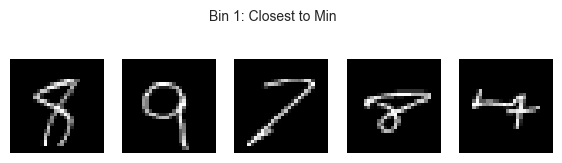

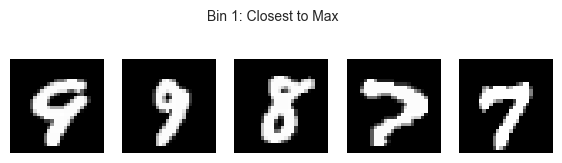

Feature 1, Bin 2: Min = 3.8861185743517654, Max = 6.653296594471592


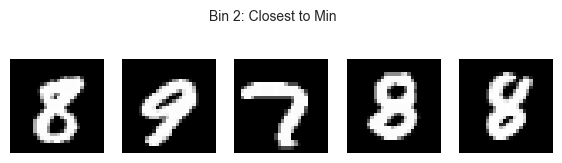

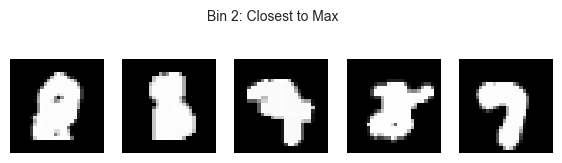

Feature 1, Bin 3: Min = 6.8304738090273895, Max = 9.53389237525011


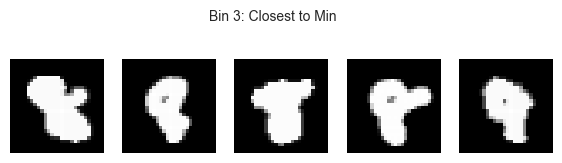

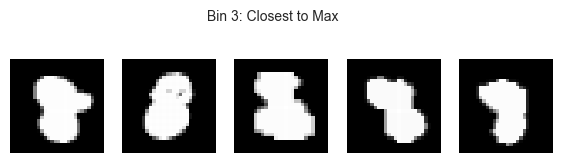

Feature 2, Bin 1: Min = 5.571777934548008, Max = 10.767758310941462


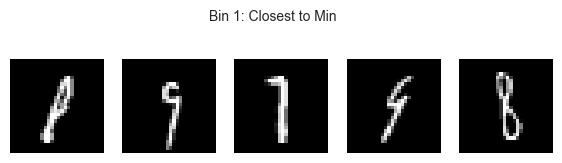

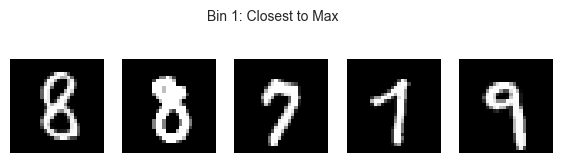

Feature 2, Bin 2: Min = 10.768987800831175, Max = 16.156074472727084


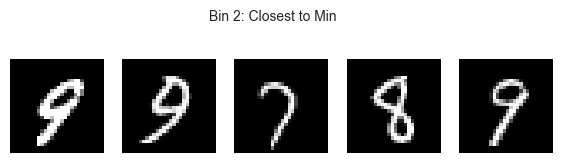

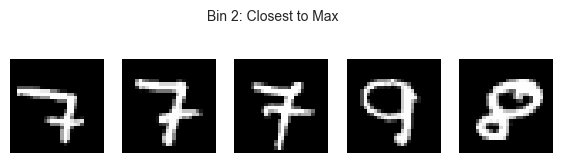

Feature 2, Bin 3: Min = 16.15746897730635, Max = 21.544126377921508


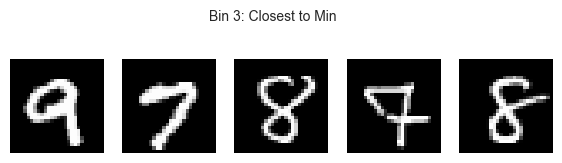

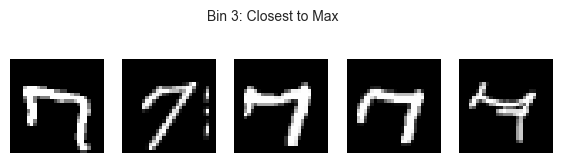

Feature 3, Bin 1: Min = 15.967514421272204, Max = 38.54898987322332


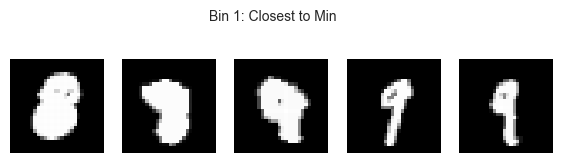

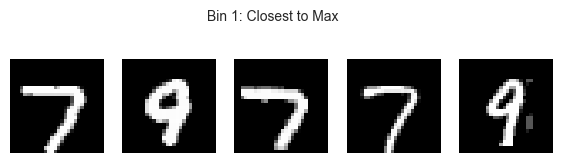

Feature 3, Bin 2: Min = 38.54898987322333, Max = 62.08757210636097


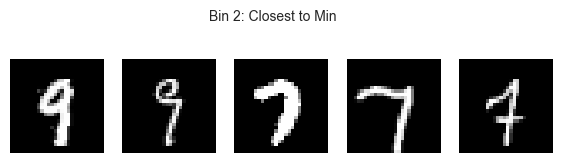

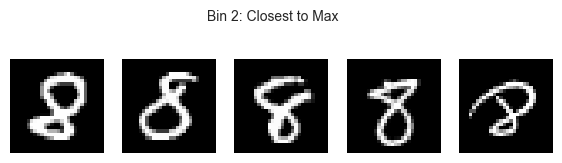

Feature 3, Bin 3: Min = 62.08757210636099, Max = 85.62615433949864


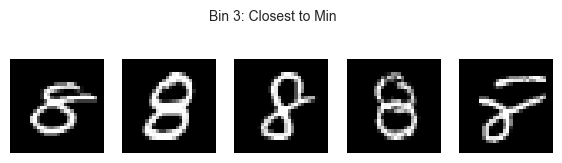

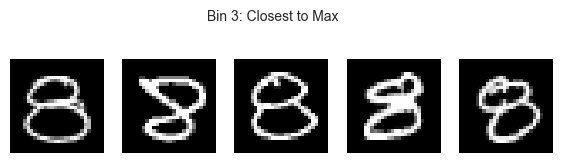

In [10]:
# Plotting the images
def plot_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(7, 2))
    fig.suptitle(title, fontsize=10)
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Plot closest images
for feature_idx in range(targets.shape[1]):
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"Feature {feature_idx + 1}, Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        
        closest_min_indices = closest_images_all[feature_idx][bin_idx][0]
        closest_max_indices = closest_images_all[feature_idx][bin_idx][1]
        
        if closest_min_indices.size > 0:
            plot_images(X[closest_min_indices], f"Bin {bin_idx + 1}: Closest to Min")
        if closest_max_indices.size > 0:
            plot_images(X[closest_max_indices], f"Bin {bin_idx + 1}: Closest to Max")

In [11]:
# Precompute the bin counts per class
def compute_class_bin_counts(targets, bins_data_all, num_bins, y):
    class_labels = np.unique(y)
    class_bin_counts = {cls: np.zeros((targets.shape[1], num_bins)) for cls in class_labels}
    
    for feature_idx in range(targets.shape[1]):
        for bin_num in range(1, num_bins + 1):
            bin_indices = bins_data_all[feature_idx][bin_num]
            for cls in class_labels:
                class_indices = np.where(y[bin_indices] == cls)[0]
                class_bin_counts[cls][feature_idx, bin_num - 1] = len(class_indices)
    
    return class_bin_counts

# Compute the class bin counts
class_bin_counts = compute_class_bin_counts(targets, bins_data_all_indices, num_bins, np.hstack(labels))

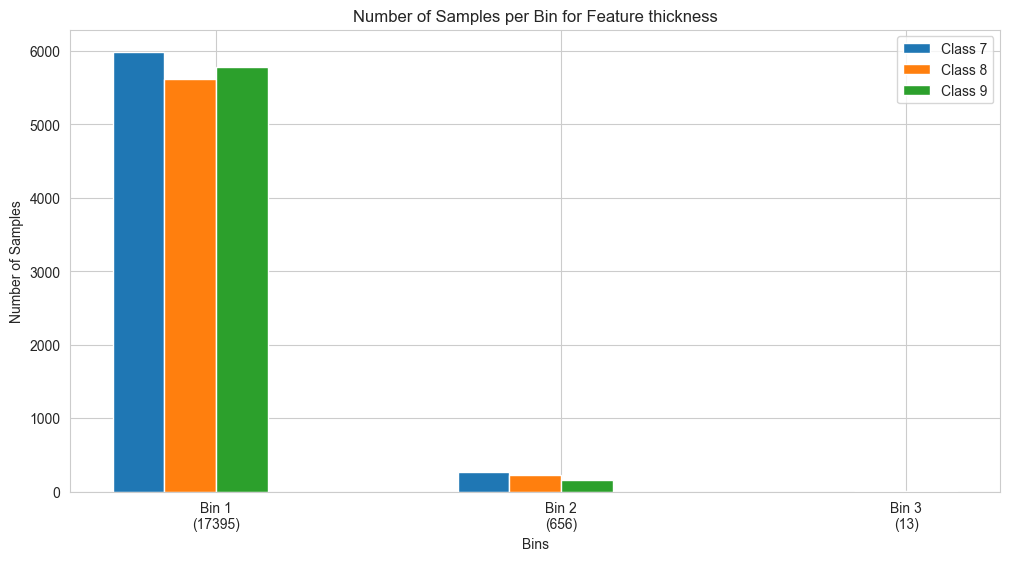

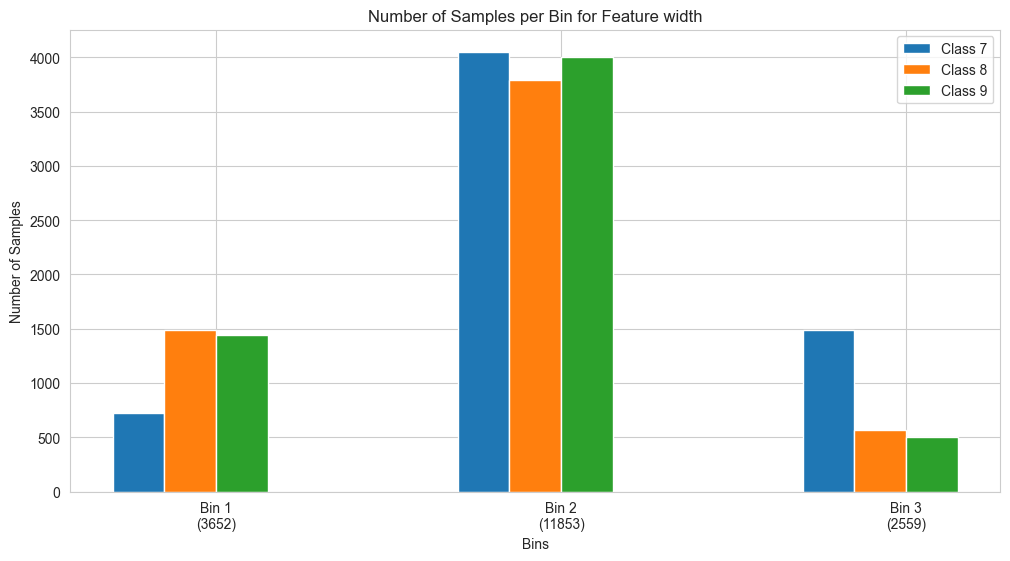

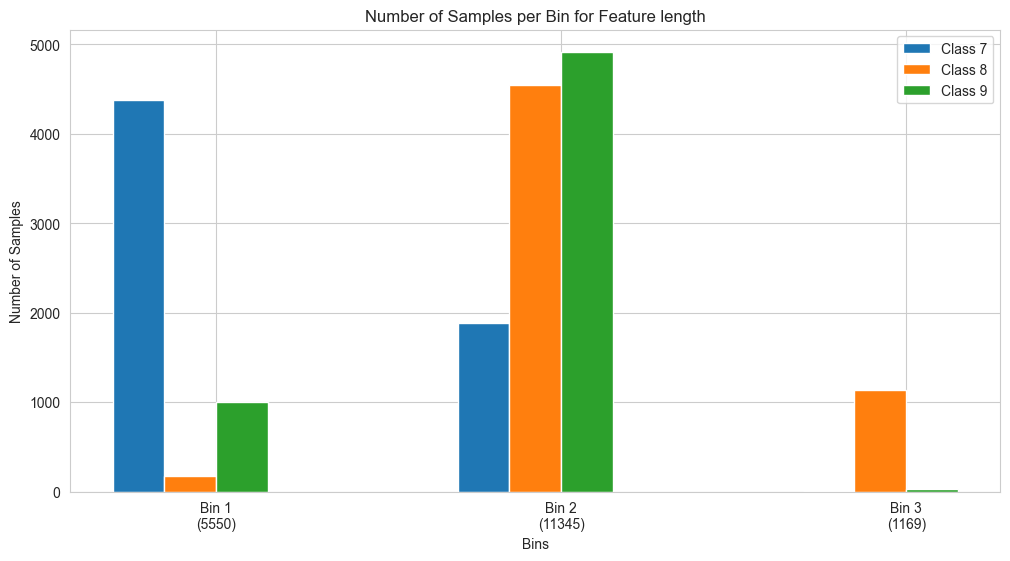

In [12]:
# Plotting the number of samples per bin per feature divided by class
for feature_idx in range(targets.shape[1]):
    bar_width = 0.15
    bin_labels = [f'Bin {i+1}\n({bin_counts[feature_idx][i]})' for i in range(num_bins)]
    r = np.arange(len(bin_labels))

    plt.figure(figsize=(12, 6))
    for cls in range(len(class_names)):
        plt.bar(r + (cls * bar_width), class_bin_counts[cls][feature_idx], width=bar_width, label=f'Class {class_index_to_name[cls]}')

    plt.xlabel('Bins')
    plt.ylabel('Number of Samples')
    plt.title(f'Number of Samples per Bin for Feature {feature_index_to_name[feature_idx]}')
    plt.xticks(r + bar_width * (len(class_names) / 2), bin_labels)
    plt.legend()
    plt.show()

#### Fit a dt to the data

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Flatten the one-hot encoded bins
X_tree = np.hstack(bins_data_all)

# Fit a decision tree classifier
dt = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(dt, X_tree, np.hstack(labels), cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")


Accuracy: 0.64 (+/- 0.01)


#### Load and visualise misscalssified images

In [14]:
path = '/Users/gouse/PycharmProjects/AR-Imperial-Thesis/logs_and_models_to_show/analysis_notebooks/digits_analysis_all_have_correct_concepts_only/model/correctly_classified_test_samples.pkl'

with open(path, 'rb') as f:
    all_concepts_correct_samples = pickle.load(f)


In [15]:
C = np.stack(bins_data_all, axis=1).reshape(-1, 9)
y = np.array([item for sublist in labels for item in sublist])
np.random.seed(42)

from sklearn.model_selection import train_test_split
# Split the data
def train_test_split_with_indices(*arrays, **options):
    # Extract the test_size and train_size parameters if they exist
    test_size = options.pop('test_size', None)
    train_size = options.pop('train_size', None)
    random_state = options.pop('random_state', None)
    shuffle = options.pop('shuffle', True)
    stratify = options.pop('stratify', None)
    indices = options.pop('indices', None)

    # Get the number of samples in the input arrays
    n_samples = arrays[0].shape[0]

    # Use provided indices or generate default indices
    if indices is None:
        indices = np.arange(n_samples)
    
    # Generate indices for the split
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, train_size=train_size, 
        random_state=random_state, shuffle=shuffle, stratify=stratify
    )

    # Split the arrays using the generated indices
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])

    # Append the indices to the result
    result.append(train_indices)
    result.append(test_indices)

    return result

X_train, X_val, C_train, C_val, y_train, y_val, train_indices, val_indices = train_test_split_with_indices(X, C, y,
                                                                  test_size=0.5,
                                                                  random_state=42)

val_index_to_or_index = {i: original_idx for i, original_idx in enumerate(val_indices)}

X_val, X_test, C_val, C_test, y_val, y_test, val_indices, test_indices = train_test_split_with_indices(X_val, C_val, y_val,
                                                                  test_size=0.5,
                                                                  random_state=42)
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
C_train = torch.tensor(C_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
C_val = torch.tensor(C_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
C_test = torch.tensor(C_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_index_to_or_index = {i: val_index_to_or_index[original_idx] for i, original_idx in enumerate(test_indices)}
test_or_index_to_index = {val_index_to_or_index[original_idx]: i for i, original_idx in enumerate(test_indices)}

/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_1850/3328805811.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_1850/3328805811.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_1850/3328805811.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


#### Sanity check: All three below should plot the same digit

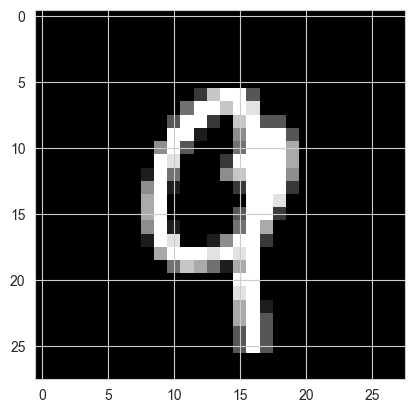

In [16]:
#plt.imshow(all_concepts_correct_samples[1]['X'].squeeze(), cmap='gray')
#plt.imshow(X_test[1].squeeze(), cmap='gray')
plt.imshow(X[test_index_to_or_index[1]].squeeze(), cmap='gray')

In [17]:
num_features = targets.shape[1]
correct_classification_dict = {feature: {bin: {} for bin in range(num_bins)} for feature in range(num_features)}
for feature_idx in range(num_features):
    for bin, indices in bins_data_all_indices[feature_idx].items():
        for idx in indices:
            if idx in test_or_index_to_index.keys():
                if test_or_index_to_index[idx] in all_concepts_correct_samples.keys():
                    if all_concepts_correct_samples[test_or_index_to_index[idx]]['C_pred_w_sigmoid'][feature_idx*(bin-1)+ (bin-1)] > 0.5:
                        correct_classification_dict[feature_idx][bin-1][idx] = {
                            'C_real': targets[idx][feature_idx],
                            'C_pred_w_sigmoid': all_concepts_correct_samples[test_or_index_to_index[idx]]['C_pred_w_sigmoid'][feature_idx*(bin-1)+ (bin-1)],
                            'class': np.hstack(labels)[idx]
                        }

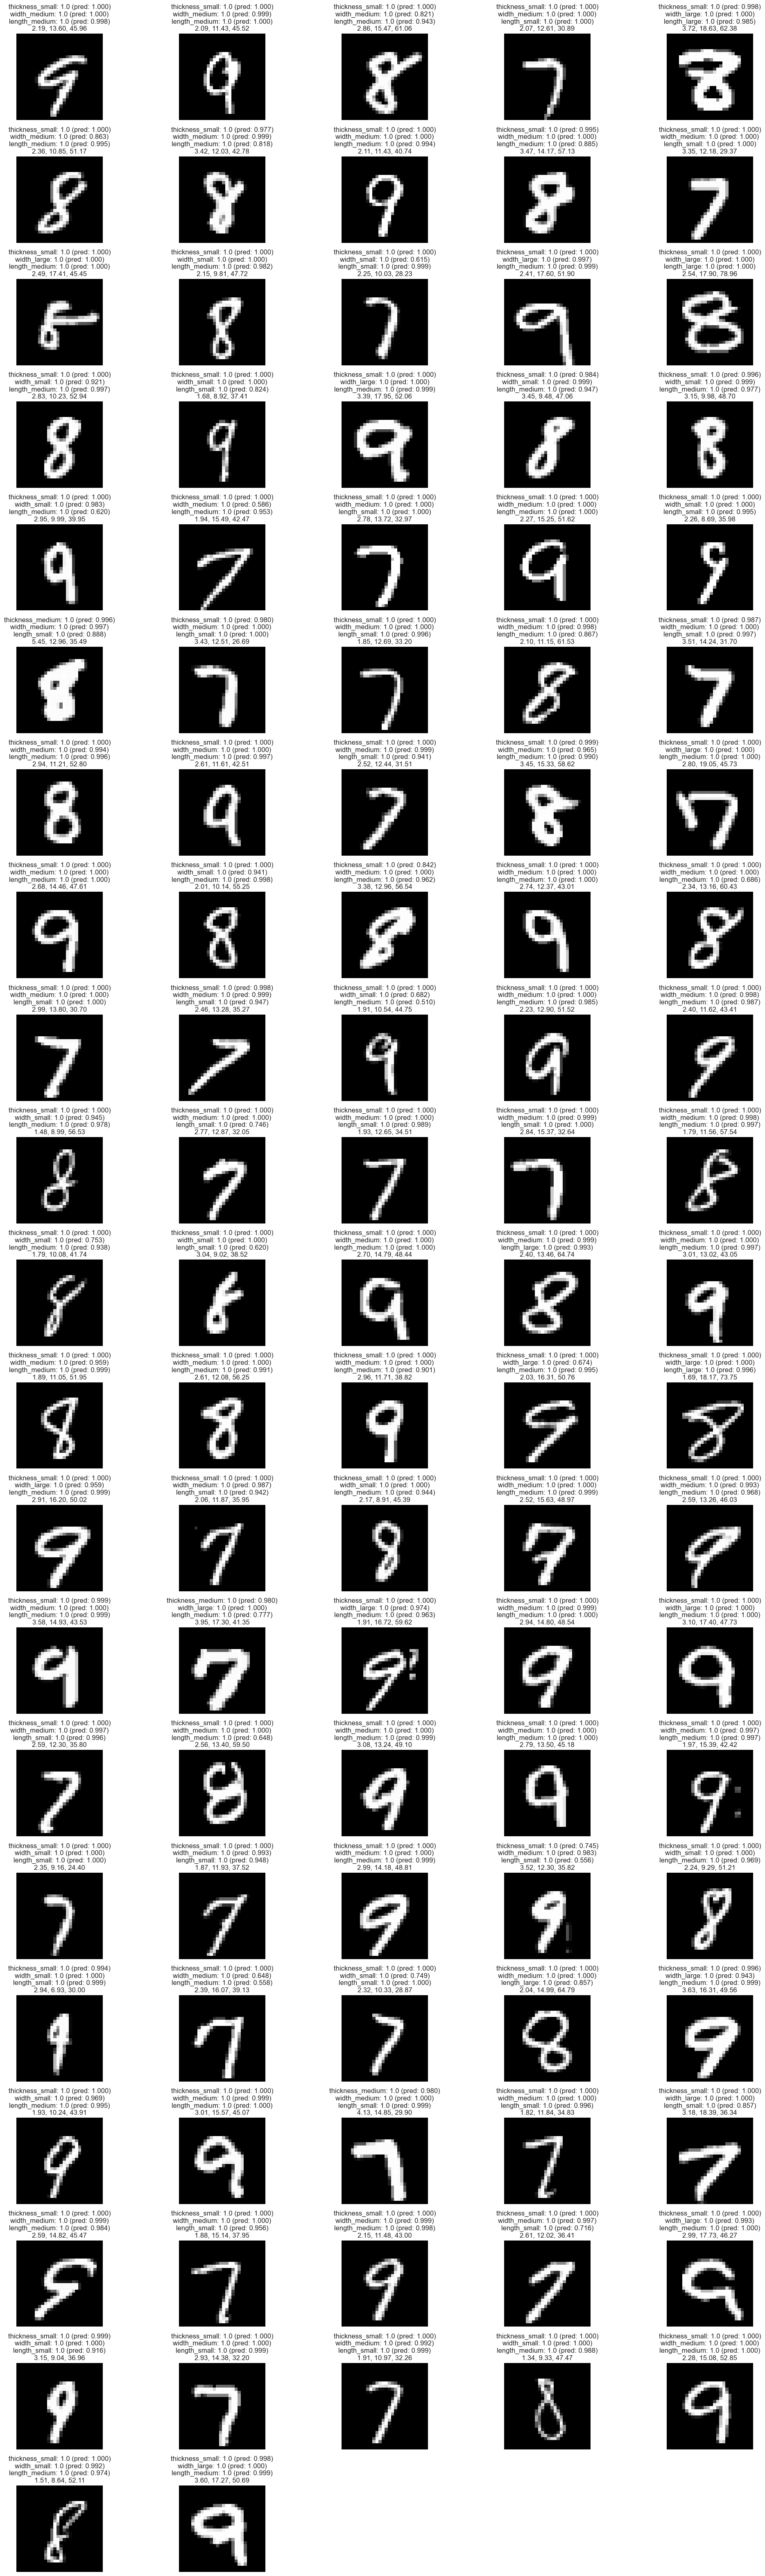

In [18]:
def plot_correct_grid(misclassified_examples, num_columns=5):

    num_samples = len(misclassified_examples)
    num_rows = (num_samples + num_columns - 1) // num_columns  # Calculate number of rows needed

    plt.figure(figsize=(20, num_rows * 3))

    for i, (idx, info) in enumerate(misclassified_examples.items()):
        input_tensor = info['X']
        correct_label = info['C']
        predicted_label = info['C_pred_w_sigmoid']

        # Find indices of misclassified elements
        bin_indices = np.where(np.array(correct_label) == 1)[0]

        # Create titles with misclassified indices
        correct_info = "\n".join([f"{feature_index_to_name_new_bins[j]}: {correct_label[j]} (pred: {predicted_label[j]:.3f})" for j in bin_indices])
        correct_info = correct_info + "\n" + ", ".join([f"{j:.2f}" for j in targets[test_index_to_or_index[idx]]])
        
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(input_tensor.squeeze(), cmap='gray')  # Assuming input_tensor is in (C, H, W) format
        plt.title(f'{correct_info}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# get the first 100 keys and values
reduced_dict = {}
for i, (idx, info) in enumerate(all_concepts_correct_samples.items()):
    reduced_dict[idx] = info
    if i > 100:
        break

plot_correct_grid(reduced_dict)

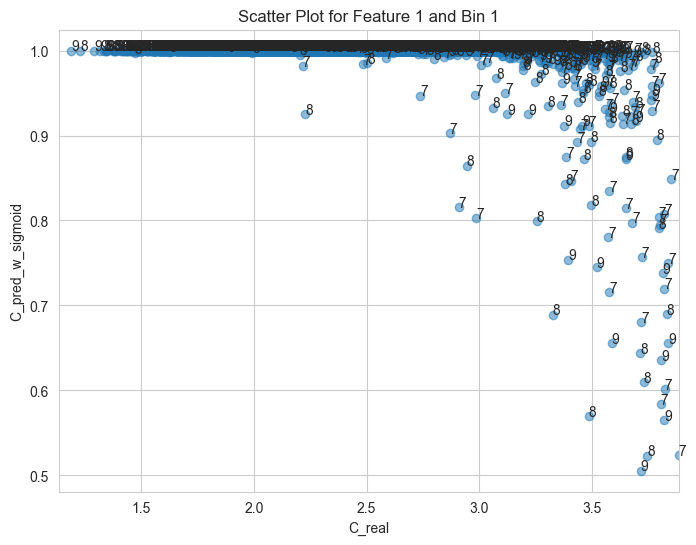

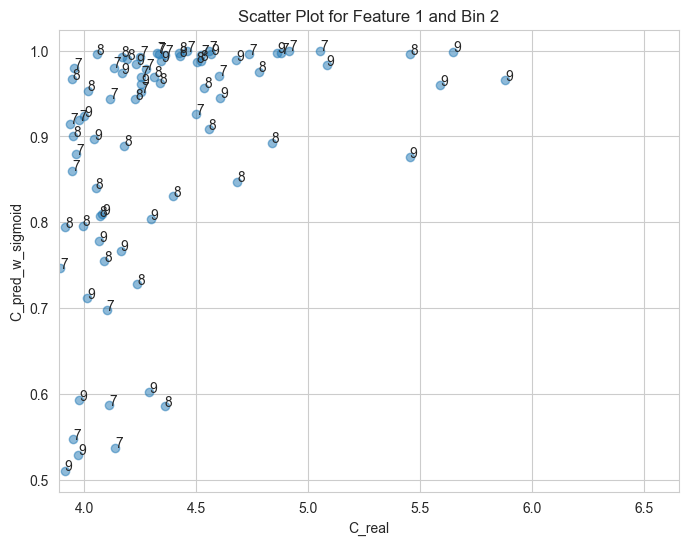

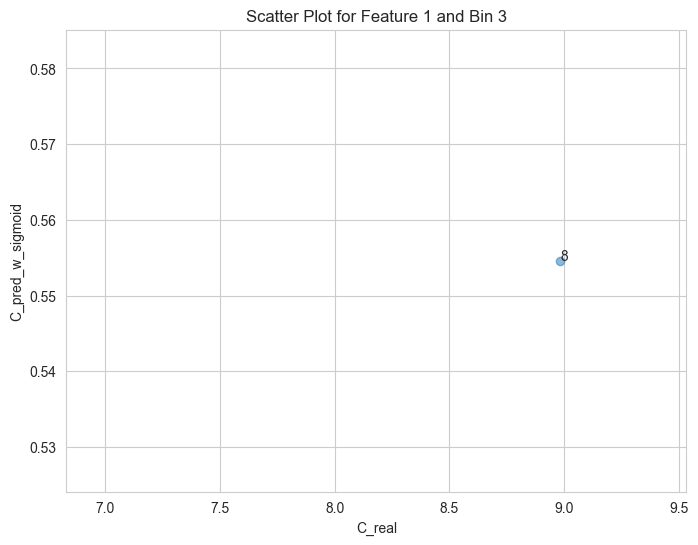

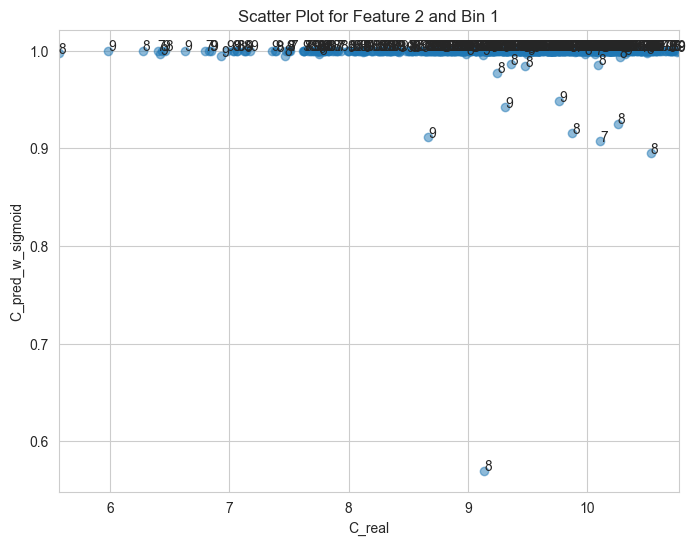

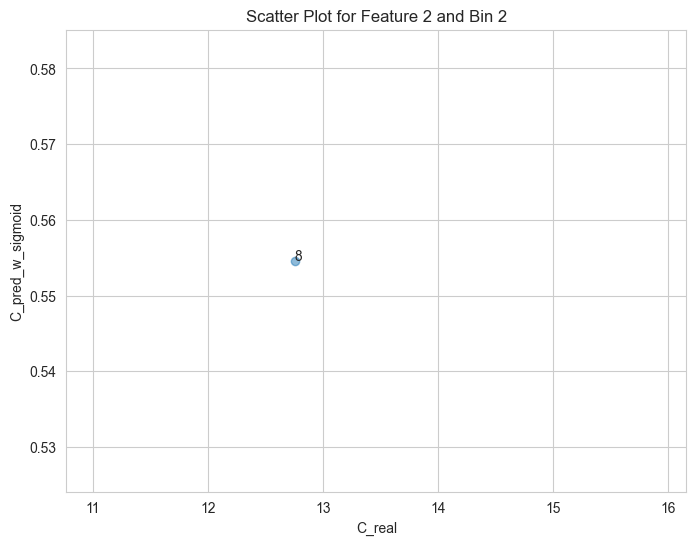

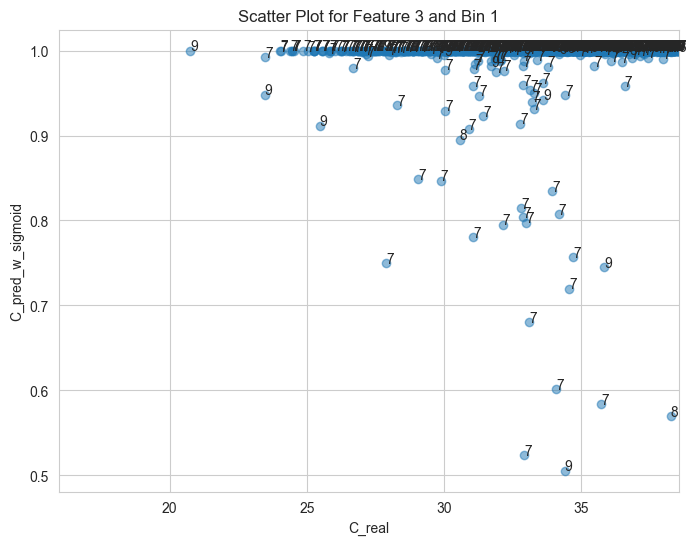

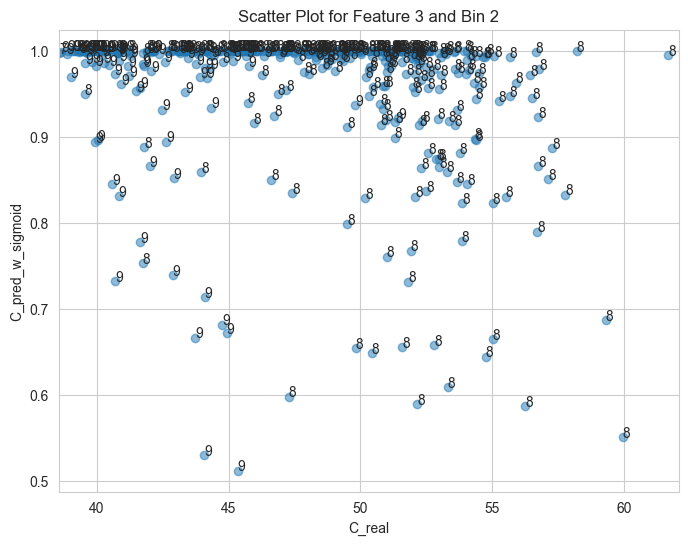

In [19]:
def plot_scatter_per_feature_bin(correct_classification_dict, num_features, num_bins):
    for feature_idx in range(num_features):
        for bin_idx in range(num_bins):
            c_real_values = []
            c_pred_values = []
            y_labels = []
            
            if bin_idx in correct_classification_dict[feature_idx]:
                for idx, values in correct_classification_dict[feature_idx][bin_idx].items():
                    c_real_values.append(values['C_real'])
                    c_pred_values.append(values['C_pred_w_sigmoid'])
                    y_labels.append(class_index_to_name[values['class']])
            
            if c_real_values and c_pred_values:
                plt.figure(figsize=(8, 6))
                plt.scatter(c_real_values, c_pred_values, alpha=0.5)
                plt.title(f'Scatter Plot for Feature {feature_idx + 1} and Bin {bin_idx + 1}')
                
                min_val, max_val = min_max_values_all[feature_idx][bin_idx]
                x_range = np.linspace(min_val, max_val, num=100)
                plt.xlim(min_val, max_val)

                plt.xlabel('C_real')
                plt.ylabel('C_pred_w_sigmoid')
                
                # Add text labels next to each dot
                for i, txt in enumerate(y_labels):
                    plt.annotate(txt, (c_real_values[i], c_pred_values[i]))
                    
                plt.grid(True)
                plt.show()
                
plot_scatter_per_feature_bin(correct_classification_dict, num_features, num_bins)